In [1]:
# Imports
import requests
import io
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from zipfile import ZipFile

In [2]:
# Obtain GBIF DCA data
download_key = "0278150-210914110416597"
download_file_url = f"https://api.gbif.org/v1/occurrence/download/request/{download_key}"
download_location = "gbif-occurrences.zip"
chunk_size = 128

r = requests.get(download_file_url, stream=True)
with open(download_location, "wb") as outfile:
    for chunk in r.iter_content(chunk_size=chunk_size):
        outfile.write(chunk)
print("done!")

done!


In [3]:
# Extract data from the zip file
with ZipFile(download_location, "r") as zip:
    zip.extractall()

# Load data GBIF DCA
occurrences = pd.read_table(f"occurrence.txt", delimiter="\t", quoting=3)
occurrences.shape

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (2,9,26,35,39,42,46,56,57,58,61,62,64,65,66,67,68,71,74,75,76,77,79,82,84,85,86,87,88,89,91,92,93,96,97,98,99,101,103,109,110,111,113,114,115,116,117,119,120,121,122,123,126,127,129,130,135,136,142,143,144,145,147,148,149,150,151,152,170,171,172,175,177,178,179,180,181,187,189,190,191,192,193,195,210,211,212,214,215,226,242,246) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(43545, 257)

In [ ]:
# Create a df of GBIF DCA columns 
list_columns = pd.DataFrame(occurrences.columns)

In [ ]:
# Export columns df
list_columns.to_csv("columns_gbif_names.csv", header=False, index=False)

In [31]:
# List of important columns
columns = ["gbifID", "institutionCode", "collectionCode", "occurrenceID", "catalogNumber", 
           "recordNumber", "recordedBy", "fieldNumber", "eventDate", "year", "month", "day",
           "eventRemarks", "countryCode", "stateProvince", "locality", "decimalLongitude", 
           "decimalLatitude", "elevation",  "habitat", "eventRemarks", "references","basisOfRecord", 
           "taxonID", "scientificNameID", "family", "genus", "species", "scientificName",
           "taxonomicStatus", "acceptedScientificName", "datasetKey", "mediaType", 
           "occurrenceRemarks", "dynamicProperties", "fieldNotes", "reproductiveCondition"]

In [32]:
# Create a dataset with selected columns
df = occurrences[columns]

In [6]:
# General stats about field notes 
print(f"{df.fieldNotes.notnull().mean() * 100:.2f} % of records have field notes")
print(f"{df.occurrenceRemarks.notnull().mean() * 100:.2f} % of records have occurrence remarks")
print(f"{df.dynamicProperties.notnull().mean() * 100:.2f} % of records have dynamic properties")
print(f"{df[['fieldNotes', 'occurrenceRemarks', 'dynamicProperties']].apply(lambda row: row.notnull().any(), axis=1).mean()*100:.2f} % or records have at least one of them")

4.56 % of records have field notes
19.76 % of records have occurrence remarks
5.86 % of records have dynamic properties
26.55 % or records have at least one of them


In [7]:
# General stats about labels
print(f"{df.reproductiveCondition.notnull().mean() * 100:.2f} % of records have field notes")

2.89 % of records have field notes


In [33]:
# Dfs of field notes
fn_df = df["occurrenceRemarks"]
fn_df = fn_df.dropna()
fn_df = df.loc[fn_df.index]
len(fn_df)

8606

In [34]:
fn_df2 = df["fieldNotes"]
fn_df2 = fn_df2.dropna()
fn_df2 = df.loc[fn_df2.index]
len(fn_df2)

1984

In [35]:
fn_df3 = df["dynamicProperties"]
fn_df3 = fn_df3.dropna()
fn_df3 = df.loc[fn_df3.index]
len(fn_df3)

2552

In [36]:
# Merge datasets
final_df = pd.concat([fn_df, fn_df2])
final_df = pd.concat([final_df, fn_df3])
# Delete duplicates
final_df = final_df.drop_duplicates()

In [37]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11562 entries, 0 to 42720
Data columns (total 37 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   gbifID                  11562 non-null  int64  
 1   institutionCode         11430 non-null  object 
 2   collectionCode          11375 non-null  object 
 3   occurrenceID            11533 non-null  object 
 4   catalogNumber           11375 non-null  object 
 5   recordNumber            8936 non-null   object 
 6   recordedBy              11220 non-null  object 
 7   fieldNumber             2132 non-null   object 
 8   eventDate               10634 non-null  object 
 9   year                    10634 non-null  float64
 10  month                   10544 non-null  float64
 11  day                     10329 non-null  float64
 12  eventRemarks            510 non-null    object 
 13  countryCode             11321 non-null  object 
 14  stateProvince           10296 non-null

In [38]:
# Merge data of images 
# Load media df
df_media = pd.read_table(f"multimedia.txt", delimiter="\t", quoting=3)

# Select useful columns 
df_media = df_media[["gbifID", "identifier"]]

# Detele NAs
non_na = df_media["identifier"].dropna()
df_media = df_media.loc[non_na.index]

# Delete duplicates
no_dup = df_media["gbifID"].drop_duplicates()
df_media = df_media.loc[no_dup.index]

# Rename identifier column 
df_media = df_media.rename(columns={"identifier":"image_url"})

In [39]:
df_media

,gbifID,image_url
0,3763061704,https://image.bgbm.org/images/internal/HerbarT...
2,3763060718,https://herbarium.bgbm.org/data/iiif/B10114828...
4,3763060710,https://herbarium.bgbm.org/data/iiif/B10114812...
6,3763059719,https://herbarium.bgbm.org/data/iiif/B10114812...
8,3763059483,https://herbarium.bgbm.org/data/iiif/B10113783...
...,...,...
21817,122907513,https://cdn.plantatlas.org/img/specimens/FTG/1...
21818,122907512,https://cdn.plantatlas.org/img/specimens/FTG/1...
21819,122907511,https://cdn.plantatlas.org/img/specimens/FTG/1...
21820,122907482,https://cdn.plantatlas.org/img/specimens/FTG/1...


In [40]:
# Add information of media to the field notes dataset
final_df = final_df.merge(df_media, on=['gbifID'], how="left")

In [41]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11562 entries, 0 to 11561
Data columns (total 38 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   gbifID                  11562 non-null  int64  
 1   institutionCode         11430 non-null  object 
 2   collectionCode          11375 non-null  object 
 3   occurrenceID            11533 non-null  object 
 4   catalogNumber           11375 non-null  object 
 5   recordNumber            8936 non-null   object 
 6   recordedBy              11220 non-null  object 
 7   fieldNumber             2132 non-null   object 
 8   eventDate               10634 non-null  object 
 9   year                    10634 non-null  float64
 10  month                   10544 non-null  float64
 11  day                     10329 non-null  float64
 12  eventRemarks            510 non-null    object 
 13  countryCode             11321 non-null  object 
 14  stateProvince           10296 non-null

## Group synonyms to the accepted names

In [42]:
# Create lists of synonyms
sp1 = ["Acalypha diversifolia Jacq.", "Acalypha angustifolia Sw.",
       "Brosimum heteroclitum Donn.Sm."]
sp2 = ["Aequatorium jamesonii (S.F.Blake) C.Jeffrey", "Aequatorium polygonoides (Cuatrec.) B.Nord.",
       "Aequatorium verrucosum (Wedd.) S.Díaz-Piedrahíta & Cuatrec."]
sp3 = ["Alchornea glandulosa Poepp.", "Alchornea glandulosa subsp. glandulosa",
       "Alchornea glandulosa subsp. iricurana (Casar.) Secco"]
sp4 = ["Allophylus floribundus (Poepp.) Radlk.", "Allophylus leiophloeus Radlk."]
sp5 = ["Annona mucosa Jacq.", "Annona parviflora (A.St.-Hil.) H.Rainer"]
sp6 = ["Axinaea macrophylla (Naudin) Triana", "Axinaea affinis (Naudin) Cogn.",
       "Axinaea floribunda (Naudin) Triana"]
sp7 = ["Bactris gasipaes Kunth", "Bactris gasipaes var. chichagui (H.Karst.) A.J.Hend.",
       "Bactris gasipaes var. gasipaes"]
sp8 = ["Beilschmiedia pendula (Sw.) Hemsl.", "Beilschmiedia brenesii C.K.Allen", 
       "Beilschmiedia costaricensis (Mez & Pittier) C.K.Allen"]
sp9 = ["Brosimum utile (Kunth) Oken", "Brosimum utile subsp. allenii (Woodson) C.C.Berg",
       "Brosimum utile subsp. darienense C.C.Berg", "Brosimum utile subsp. magdalenense C.C.Berg",
       "Brosimum utile subsp. magdalense C.C.Berg, 1970", "Brosimum utile subsp. occidentale C.C.Berg",
       "Brosimum utile subsp. ovatifolium (Ducke) C.C.Berg", "Brosimum utile subsp. utile"]
sp10 = ["Alsophila incana (H.Karst.) D.S.Conant", "Cyathea poeppigii (Hook.) Domin"]

In [43]:
# Create a new column with no-synonyms names
new_column = []

for i in final_df.index:
    if final_df['acceptedScientificName'][i] in sp1:
        new_column.append(sp1[0])
    elif final_df['acceptedScientificName'][i] in sp2:
        new_column.append(sp2[0])
    elif final_df['acceptedScientificName'][i] in sp3:
        new_column.append(sp3[0])
    elif final_df['acceptedScientificName'][i] in sp4:
        new_column.append(sp4[0])
    elif final_df['acceptedScientificName'][i] in sp5:
        new_column.append(sp5[0])
    elif final_df['acceptedScientificName'][i] in sp6:
        new_column.append(sp6[0])
    elif final_df['acceptedScientificName'][i] in sp7:
        new_column.append(sp7[0])
    elif final_df['acceptedScientificName'][i] in sp8:
        new_column.append(sp8[0])
    elif final_df['acceptedScientificName'][i] in sp9:
        new_column.append(sp9[0])
    elif final_df['acceptedScientificName'][i] in sp10:
        new_column.append(sp10[0])
    else : #if both conditions not verified
        new_column.append(final_df['acceptedScientificName'][i])

final_df['acceptedScientificName_corr'] = new_column

In [44]:
len(final_df["acceptedScientificName_corr"].unique())

47

## Countries names

In [48]:
final_df['Country_name'] = final_df.countryCode.map({"AQ": "Antarctica", "AR":"Argentina",
                                                     "AU":"Australia", "BO": "Bolivia", 
                                                     "BR":"Brazil","BZ": "Belize", 
                                                     "CN":"China","CO": "Colombia", 
                                                     "CR":"Costa Rica","CU": "Cuba", 
                                                     "DO":"Dominican Republic","EC": "Ecuador", 
                                                     "GF":"French Guiana","GN": "Guinea", 
                                                     "GP":"Guadeloupe","GT": "Guatemala", 
                                                     "GY":"Guyana","HN": "Honduras", 
                                                     "HT":"Haiti","JM": "Jamaica", 
                                                     "KN":"St. Kitts and Nevis","MQ": "Martinique", 
                                                     "MX":"Mexico","NI": "Nicaragua", 
                                                     "PA":"Panama","PE": "Peru", 
                                                     "PR":"Puerto Rico","PY": "Paraguay", 
                                                     "SR":"Suriname","SV": "El Salvador", 
                                                     "TT":"Trinidad & Tobago","US": "United States of America", 
                                                     "UY":"Uruguay","VC": "St. Vincent & the Grenadines", 
                                                     "VE":"Venezuela","ZZ": "Unknown",}).fillna("Unknown")

In [49]:
countries = pd.DataFrame(final_df["Country_name"].unique(), 
                    columns = ["Country_name"])

countries = countries.sort_values(by=["Country_name"], ignore_index=True)

df_counts_c = pd.DataFrame(columns=["Country_name", "count"])

for i in countries["Country_name"]:
  count_temp = len(final_df[final_df["Country_name"] == i])
  df_counts_c.loc[len(df_counts_c)] = [i, count_temp]

In [50]:
df_counts_c["count"].sum()

11562

In [51]:
len(final_df['Country_name'].unique())

36

In [52]:
# Delete records from countries outside America
final_df = final_df.drop(final_df[(final_df.Country_name == "Antarctica") | 
                                  (final_df.Country_name == "Australia") | 
                                  (final_df.Country_name == "China") |
                                  (final_df.Country_name == "Guinea")].index)

In [53]:
len(final_df['Country_name'].unique())

32

## Add filter columns

In [62]:
# Add a column to verify if records have dates with at least month
final_df["Date_with_month"] = final_df['month'].isna()
final_df["Date_with_month"] = final_df["Date_with_month"].replace({True: 'No', False: 'Yes'})

In [68]:
# Add a column to verify if records have latitude
final_df["Latitute_verif"] = final_df['decimalLatitude'].isna()
final_df["Latitute_verif"] = final_df["Latitute_verif"].replace({True: 'No', False: 'Yes'})

In [72]:
# Add a column to verify if records have longitude
final_df["Longitude_verif"] = final_df['decimalLongitude'].isna()
final_df["Longitude_verif"] = final_df["Longitude_verif"].replace({True: 'No', False: 'Yes'})

## Create a column for binned latitude

In [78]:
test = final_df[final_df['decimalLatitude'].isna() == False]["decimalLatitude"]

In [94]:
max(test)

74.833333

In [102]:
# Create a list with the bins
start = -70
n = 80
interval = 10
bins = np.arange(start, n, interval)

# Create a column with the binned latitude
final_df['Binned_latitude'] = pd.cut(final_df['decimalLatitude'], bins)

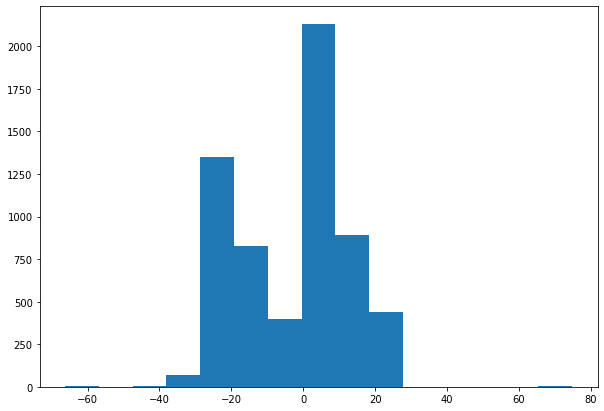

In [108]:
# Create an histogram with the binned latitude
n_bins = 15
# Creating histogram
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(test,  bins = n_bins)
 
# Show plot
plt.show()

In [109]:
# Export final dataset
final_df.to_csv("50_species_GBIFrecords_fieldnotes.csv", index=False)

## Other tests

In [ ]:
test = pd.DataFrame(final_df["countryCode"].unique(), columns = ["countryCode"])

In [ ]:
test = test.sort_values(by=["countryCode"], ignore_index=True)

In [ ]:
test

,countryCode
0,AQ
1,AR
2,AU
3,BO
4,BR
5,BZ
6,CN
7,CO
8,CR
9,CU


In [ ]:
test.to_csv("accepted_names_list.csv", index=False)

In [ ]:
len(final_df[final_df["acceptedScientificName"] == "Acalypha diversifolia Jacq."])

1321

In [ ]:
temp = pd.DataFrame(columns=["countryCode", "count"])

In [ ]:
for i in test["countryCode"]:
  count_temp = len(final_df[final_df["countryCode"] == i])
  temp.loc[len(temp)] = [i, count_temp]

In [ ]:
temp

,acceptedScientificName,count
0,Acalypha angustifolia Sw.,2
1,Acalypha diversifolia Jacq.,1321
2,Aegiphila aculeifera Moldenke,4
3,Aegiphila alba Moldenke,32
4,Aegiphila bogotensis (Spreng.) Moldenke,78
...,...,...
64,Browneopsis macrofoliolata Klitg.,3
65,Brunellia acostae Cuatrec.,24
66,Cyathea conjugata (Spruce ex Hook.) Domin,88
67,Cyathea poeppigii (Hook.) Domin,2


In [ ]:
temp["count"].sum()

11562